In [1]:
import awkward as ak
import vector
import hist
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import uproot

from atlas_schema.schema import NtupleSchema
from coffea import dataset_tools
from coffea.nanoevents import NanoEventsFactory

vector.register_awkward()
mplhep.style.use(mplhep.style.ATLAS1)

In [2]:
!pip install servicex
from servicex import dataset, query, deliver

  Using cached servicex-3.2.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached aioboto3-15.2.0-py3-none-any.whl.metadata (8.9 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached func_adl-3.5.0-py3-none-any.whl.metadata (12 kB)
  Using cached httpx_retries-0.4.3-py3-none-any.whl.metadata (4.1 kB)
  Using cached make_it_sync-2.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached qastle-0.19.0-py3-none-any.whl.metadata (8.1 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached tinydb-4.8.2-py3-none-any.whl.metadata (6.7 kB)
  Using cached typer-0.19.2-py3-none-any.whl.metadata (16 kB)
  Using cached types_pyyaml-6.0.12.20250915-py3-none-any.whl.metadata (1.7 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached boto3-1.40.18-py3-none-any.whl.metadata (6.7 kB)
  Using cached s3transfer-0.13.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB

## Getting the data 
 ####    Opendata on local file system for this mini-demo 

In [3]:
fileset = {
    "Zprimett": {
        "files": {"/data/alheld/integration-challenge/301333/38191516._000001.root": "reco"},
        "metadata": {"meta": 0}
    },
    "ttbar": {
        "files": {
            "/data/alheld/integration-challenge/410470/37620644._000012.root": "reco",
        },
        "metadata": {"meta": 0}
    }
}

#### Ultimately, we will make use of ServiceX
- Fetch centrally produced data (ntuple) with Rucio
- Apply selection cuts
- Optional:
    - run TopCPToolKit in the backend
        - Produce ntuples from Physlite 
        - amount of allowed systematic computing TBD

Interface example:

In [4]:
#1) Build dataset 
rucio_did="user.acordeir:nominal_trig_overlap_obj_dump_sys_zprime3k.root"
ds=dataset.Rucio(rucio_did)

#2) Write transformation
ds_query = query.UprootRaw(
    [
        {
            "treename": "reco",
            "filter_name": ["*jet_*", "*el_*"], 
            "cut": "num(el_pt_NOSYS)>0",
        }
    ]
)

#3) Write deliver config
spec = {
    "Sample": [{"Name": "from_rucio", "Dataset": ds, "Query": ds_query}],
}

#4) Get the data 
delivered_file = deliver(spec)

#fileset["rucio_signal"]={
#    "files": {delivered_file["from_rucio"][0]: "servicex"},
#    "metadata": {"meta": 0}
#}

Output()

## NanoEventsFactory
 - Lazy loading with virtual arrays 
 - Ntuple ATLAS schema for tracking systematic uncertainty branches

In [5]:
events = NanoEventsFactory.from_root(fileset["Zprimett"]["files"], mode="virtual", schemaclass=NtupleSchema).events()

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : ['mcEventWeights', 'dataTakingYear', 'lumiBlock']
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])
/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])


#### ATLAS systematic handling has never been so easy!

In [6]:
#access list of systematic branches
events.systematic_names[0:3]

['NOSYS', 'EG_RESOLUTION_AF3__1down', 'EG_RESOLUTION_AF3__1up']

In [7]:
f"Ntuple contains {len(events.systematic_names)} systematics"

'Ntuple contains 313 systematics'

### Easily access specific variations and evaluate them

In [8]:
jer_variations=[s for s in events.systematic_names if "JER" in s]

Text(0, 1, 'Entries')

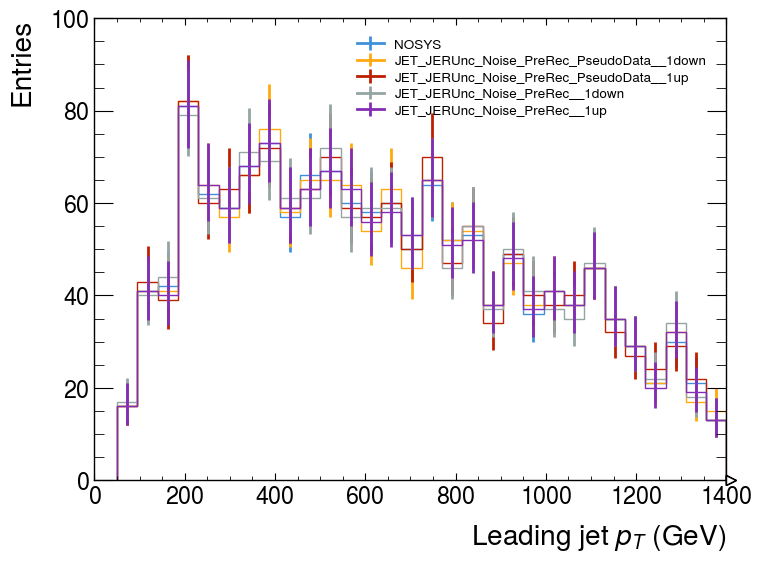

In [9]:
h = hist.new.Regular(30, 50, 1400, label="Leading jet $p_T$ (GeV)").StrCat([], name="variation", growth=True).Double()

for variation in ["NOSYS"] + jer_variations[0:4]:
    event_view = events[variation]
    h.fill(event_view.jet.pt[:, 0] / 1_000, variation=variation)


fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
    
ax.legend(fontsize="x-small", loc=1)
ax.set_ylabel("Entries")

## Coffea processor approach 
#### Distributed workers

In [10]:
from dask.distributed import Client, PipInstall

client = Client("tls://localhost:8786")

plugin = PipInstall(packages=["atlas_schema", "atlasopenmagic"], pip_options=["--upgrade"])
client.register_plugin(plugin)

In [10]:
from coffea import processor

def get_xsec_norm(dsid):
    # not including normalization by sum of weights (that one depends on the number of files processed)
    lumi = 36646.74 # / pb
    meta = atlasopenmagic.get_metadata(dsid)
    return lumi * meta["cross_section_pb"] * meta["kFactor"] * meta["genFiltEff"]


class Analysis(processor.ProcessorABC):
    def __init__(self):
        self.h = hist.new.Regular(12, 0, 300, label="leading jet $p_T$").\
            StrCat([], name="dsid", growth=True).StrCat([], name="variation", growth=True).\
            Weight()

    def process(self, events):
        f = uproot.open(events.metadata["filename"])
        sim_type, mc_campaign, dsid, etag = f["metadata"].axes[0]
        sumw = float(f[f"CutBookkeeper_{dsid}_284500_NOSYS"].values()[1])  # initial sum of weights
        systematics_from_hist = list(f["listOfSystematics"].axes[0])
        list_of_variations =  events.systematic_names
        # ensure systematics in schema and in histogram match
        assert sorted(systematics_from_hist) == sorted(list_of_variations)  

        # run over subset of systematics
        for variation in ["NOSYS"] + [sys for sys in events.systematic_names if sys.startswith("JET_JER_EffectiveNP_1_")]:
            print(variation)
            event_view = events[variation]
            self.h.fill(event_view.jet.pt[:, 0] / 1_000, dsid=dsid, variation=variation, weight=event_view.weight.mc)
        return {
            "hist": self.h,
            "meta": {
                "sumw": {dsid: {(events.metadata["fileuuid"], sumw)}}}  # sumw in set to avoid summing
        }  

    def postprocess(self, accumulator):
        # normalize histograms
        # https://topcptoolkit.docs.cern.ch/latest/starting/running_local/#sum-of-weights
        for dsid in accumulator["hist"].axes[1]:
            norm = get_xsec_norm(dsid) / sum([sumw for uuid, sumw in accumulator["meta"]["sumw"][dsid]])
            accumulator["hist"][:, dsid, :] = np.stack([accumulator["hist"][:, dsid, :].values()*norm, accumulator["hist"][:, dsid, :].variances()*norm**2], axis=-1)


In [ ]:
run = processor.Runner(
    executor = processor.IterativeExecutor(),
    schema=NtupleSchema,
    savemetrics=True,
    chunksize=50000
)
samples = run.preprocess(fileset)

out, report = run(samples, processor_instance=Analysis())

out, report

Output()

Output()

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: Missing event_ids : 
['mcEventWeights', 'dataTakingYear', 'lumiBlock']
  self._build_collections(self._form["fields"], self._form["contents"])

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no 
defined mixin: 'globalTriggerEffSF'. I will assume behavior: 'NanoCollection'. To suppress this warning next time, 
please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])

/usr/local/lib/python3.12/site-packages/atlas_schema/schema.py:175: RuntimeWarning: I found a collection with no 
defined mixin: 'globalTriggerMatch'. I will assume behavior: 'Systematic'. To suppress this warning next time, 
please define mixins for your custom collections. [mixin-undefined]
  self._build_collections(self._form["fields"], self._form["contents"])

NOSYS

In [ ]:
dsid = "301333"
h = out["hist"]

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=(3, 1), constrained_layout=True, sharex=True)
h[:, dsid, :].plot(ax=ax1, linewidth=2)
ax1.legend()
ax1.set_ylabel("count")

edges = h[:, dsid, :].axes[0].edges
ax2.plot(edges, [1]*len(edges), color="black", linestyle="dashed", linewidth=1)
for ivar, variation in enumerate(h.axes[2]):
    if variation == "NOSYS":
        continue
    print(ivar, variation)
    # print(h[:, dsid, variation], 
    ratio = (h[:, dsid, variation].values() / h[:, dsid, "NOSYS"].values())
    ax2.stairs(ratio, edges, color=f"C{ivar}", linewidth=2)
ax2.set_ylabel("var/nom")
ax2.set_ylim([0.8, 1.2])

## Would be followed by Statistical modeling 
### Cabinatery, PyHF, TRexFitter